In [1]:
import torch

torch.manual_seed(1)

In [2]:
import glob

#TODO: Если не созданы тайлы, то надо запустить src/preprocessing/tile_generating.py

tiles_folders = glob.glob("../data/digital_leaders/tiles/*")
len(tiles_folders)

21

In [3]:
from sklearn.model_selection import train_test_split
import os

train_folders, val_folders = train_test_split(tiles_folders, test_size=0.2)
train_paths = []
val_paths = []
for folder in train_folders:
    train_paths.extend(glob.glob(os.path.join(folder, "images", "*.png")))
for folder in val_folders:
    val_paths.extend(glob.glob(os.path.join(folder, "images", "*.png")))
len(train_paths), len(val_paths)

(2093, 831)

In [4]:
from torch.utils.data import Dataset
import cv2


class TileDataset(Dataset):
    def __init__(self, paths, transforms=None):
        self.paths = paths
        self.transforms = transforms

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_path = path.replace("images", "masks").replace("tile_", "mask_tile_")
        mask = cv2.imread(mask_path)[:, :, 0]
        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask

In [5]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

train_transforms = A.Compose(
    [
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [6]:
train_dataset = TileDataset(train_paths, train_transforms)
val_dataset = TileDataset(val_paths, val_transforms)

In [7]:
def CHW2HWC(image):
    return image.permute(2, 1, 0)

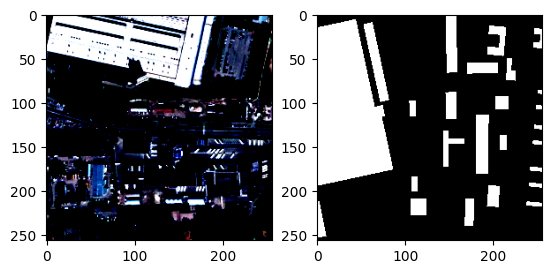

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


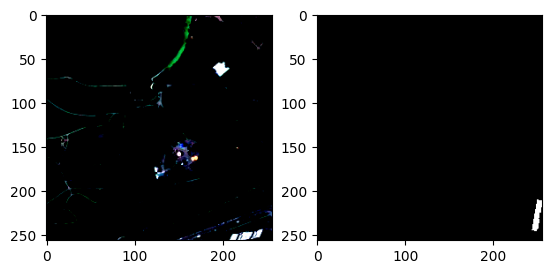

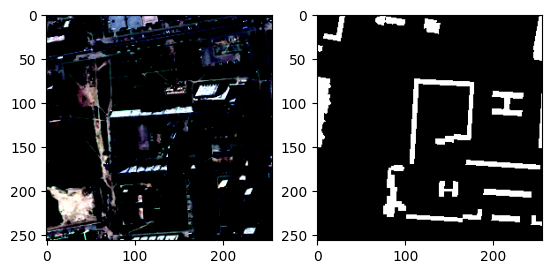

In [8]:
import matplotlib.pyplot as plt

k = 0
for image, mask in train_dataset:
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(CHW2HWC(image).numpy())
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.show()

    k += 1
    if k == 3:
        break

In [9]:
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True
)

In [10]:
from torchgeo.models import ResNet50_Weights
import segmentation_models_pytorch as smp

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
weights = ResNet50_Weights.SENTINEL2_RGB_MOCO
model = smp.UnetPlusPlus(encoder_name="efficientnet-b0", encoder_weights=None,
                         in_channels=weights.meta["in_chans"], classes=1,
                         activation="sigmoid")
# model.encoder.load_state_dict(weights.get_state_dict(), strict=False)
model.to(device)

cuda


UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSam

In [11]:
from src.modelling.metrics import DiceMetric, IoULoss

criterion = IoULoss()
metric = DiceMetric()

In [12]:
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR

epochs = 10
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
scheduler = OneCycleLR(optimizer, max_lr=lr, epochs=epochs,
                       steps_per_epoch=len(train_loader))

In [13]:
from src.modelling.train import run

run(model=model, train_loader=train_loader, val_loader=val_loader,
    criterion=criterion, metric=metric, optimizer=optimizer,
    scheduler=scheduler, epochs=epochs, device=device,
    save_name="unet_plus_plus.pth", weights_path="../artifacts/weights")

Epoch #1


  0%|          | 0/66 [00:00<?, ?it/s]

      Score    |    Loss
Train: 0.194741 | 0.908305


  0%|          | 0/26 [00:00<?, ?it/s]

Val: 0.089330 | 0.932376

Epoch #2


  0%|          | 0/66 [00:00<?, ?it/s]

      Score    |    Loss
Train: 0.349831 | 0.848907


  0%|          | 0/26 [00:00<?, ?it/s]

Val: 0.245849 | 0.874377

Epoch #3


  0%|          | 0/66 [00:00<?, ?it/s]

KeyboardInterrupt: 